This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import time
import sys
import gc
import pickle

from fastai.structured import *
from fastai.column_data import *

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
cats = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train.csv')
# set index to ID to avoid dropping it later
test  = pd.read_csv('data/test.csv').set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [ ]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [ ]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [ ]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [ ]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [ ]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

In [ ]:
%%time
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [ ]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [ ]:
%%time
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

## Test set
To use time tricks append test pairs to the matrix.

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [ ]:
%%time
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

## Shops/Items/Cats features

In [ ]:
%%time
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

## Traget lags

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
%%time
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

## Mean encoded features

In [ ]:
%%time
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
%%time
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

## Trend features

Price trend for the last six months.

In [ ]:
%%time
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

Last month shop revenue trend

In [ ]:
%%time
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

## Special features

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [ ]:
%%time
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

In [ ]:
%%time
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         

Months since the first sale for each shop/item pair and for item only.

In [ ]:
%%time
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
matrix = matrix[matrix.date_block_num > 11]

Producing lags brings a lot of nulls.

In [ ]:
%%time
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [ ]:
matrix.dtypes

In [2]:
dep = 'item_cnt_month'

excluded_cols = ['date_block_num', 'item_cnt_month', 'date_shop_subtype_avg_item_cnt_lag_1', 
                 'date_shop_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
                 'date_type_avg_item_cnt_lag_1', 'delta_revenue_lag_1']

cat_cols = [_f for _f in matrix.columns 
            if (matrix[_f].dtype == 'int8' or matrix[_f].dtype == 'int16') and _f not in excluded_cols]

contin_cols = [_f for _f in matrix.columns 
            if matrix[_f].dtype == 'float16' and _f not in excluded_cols]

NameError: name 'matrix' is not defined

In [3]:
cat_cols, contin_cols

NameError: name 'cat_cols' is not defined

In [ ]:
matrix.to_pickle('data_lesser.pkl')

del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [2]:
data = pd.read_pickle('data_lesser.pkl')

Select perfect features

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [3]:
dep = 'item_cnt_month'

excluded_cols = [#'date_shop_subtype_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
                 #'date_shop_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
                 'date_block_num', 'item_cnt_month', 'delta_revenue_lag_1']

cat_cols = [_f for _f in data.columns 
            if (data[_f].dtype == 'int8' or data[_f].dtype == 'int16') and _f not in excluded_cols]

contin_cols = [_f for _f in data.columns 
            if data[_f].dtype == 'float16' and _f not in excluded_cols]

In [4]:
X_train = data[cat_cols + contin_cols + [dep, 'date_block_num']].copy()

X_test = data[cat_cols + contin_cols + [dep, 'date_block_num']].copy()[data.date_block_num == 34]

In [5]:
len(X_train.columns), len(data.columns), set(data.columns).difference(set(X_train.columns))

(20, 21, {'delta_revenue_lag_1'})

In [6]:
for _f in cat_cols: 
    print(_f)
    X_train[_f] = X_train[_f].astype('category').cat.as_ordered()

shop_id
item_id
city_code
item_category_id
type_code
subtype_code
month
days
item_shop_last_sale
item_last_sale
item_shop_first_sale
item_first_sale


In [7]:
apply_cats(X_test, X_train)

In [8]:
X_train_indexed = X_train.set_index('date_block_num')
X_test_indexed = X_test.set_index('date_block_num')

In [9]:
val_len = len(X_train_indexed[X_train_indexed.index == 33])
val_len

238172

In [10]:
val_idx = list(range(len(X_train_indexed) - val_len, len(X_train_indexed)))

In [11]:
len(val_idx), (len(val_idx) / len(X_train_indexed) * 100)

(238172, 3.587309132567409)

# Prepare Learner from pandas dataframe

In [12]:
X_train_indexed[dep] = X_train_indexed[dep].astype('float32')
X_test_indexed[dep] = X_test_indexed[dep].astype('float32')

In [13]:
X_train_indexed[contin_cols] = X_train_indexed[contin_cols].astype('float32')
X_test_indexed[contin_cols] = X_test_indexed[contin_cols].astype('float32')

In [14]:
df, y, nas, mapper = proc_df(X_train_indexed, 'item_cnt_month', do_scale=True)

In [15]:
df_test, _, nas, mapper = proc_df(X_test_indexed, 'item_cnt_month', do_scale=True, mapper=mapper, na_dict=nas)

In [16]:
def exp_rmse(y_pred, targ):
    return math.sqrt(mean_squared_error(targ, y_pred))

In [17]:
yl = np.log1p(y)
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [18]:
cat_sz = [(c, len(X_train_indexed[c].cat.categories)+1) for c in cat_cols]

In [19]:
cat_sz

[('shop_id', 55),
 ('item_id', 17433),
 ('city_code', 32),
 ('item_category_id', 81),
 ('type_code', 21),
 ('subtype_code', 64),
 ('month', 13),
 ('days', 4),
 ('item_shop_last_sale', 35),
 ('item_last_sale', 35),
 ('item_shop_first_sale', 36),
 ('item_first_sale', 36)]

In [24]:
emb_szs = [(c, max(5, min(100, (c+1)//2))) for _,c in cat_sz]

In [25]:
emb_szs

[(55, 28),
 (17433, 100),
 (32, 16),
 (81, 41),
 (21, 11),
 (64, 32),
 (13, 7),
 (4, 5),
 (35, 18),
 (35, 18),
 (36, 18),
 (36, 18)]

In [26]:
import warnings; warnings.simplefilter('ignore')

In [27]:
md = ColumnarModelData.from_data_frame('data', val_idx, df, yl, cat_flds=cat_cols, bs=2048,
                                       test_df=df_test)

In [28]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [29]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(55, 28)
    (1): Embedding(17433, 100)
    (2): Embedding(32, 16)
    (3): Embedding(81, 41)
    (4): Embedding(21, 11)
    (5): Embedding(64, 32)
    (6): Embedding(13, 7)
    (7): Embedding(4, 5)
    (8): Embedding(35, 18)
    (9): Embedding(35, 18)
    (10): Embedding(36, 18)
    (11): Embedding(36, 18)
  )
  (lins): ModuleList(
    (0): Linear(in_features=318, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [30]:
#lr = 9e-5
m.lr_find()

epoch      trn_loss   val_loss                                                                                         
    0      0.157017   0.013658  



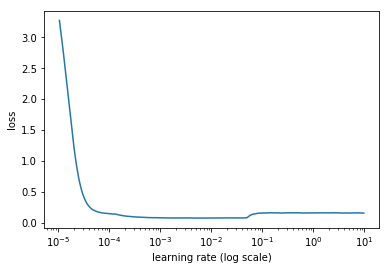

In [31]:
m.sched.plot()

In [33]:
lr = 5e-5

In [34]:
lr

5e-05

In [35]:
m.fit(lr, 1, cycle_len = 3, metrics=[exp_rmse])

epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      0.080787   0.088605   0.280732  
    1      0.075437   0.090878   0.280891                                                                              
    2      0.074034   0.088492   0.276469                                                                              



[0.08849215954450033, 0.2764691752541095]

In [36]:
m.save('predict_sales_fastai3E')

In [41]:
m.load('predict_sales_fastai3E')

In [37]:
m.fit(lr, 2, cycle_len = 2, cycle_mult = 2, metrics=[exp_rmse])

epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      0.070494   0.088562   0.273652  
    1      0.068179   0.090336   0.275608                                                                              
 93%|████████████████████████████████████████████████████████████▎    | 2900/3126 [01:55<00:09, 25.04it/s, loss=0.0674]

KeyboardInterrupt: 

In [43]:
m.save('predict_sales_fastai4E')

# Test Set

In [57]:
x,y=m.predict_with_targs()
exp_rmse(x,y)

0.24295375722520368

In [59]:
log_preds = m.predict(True)

In [60]:
log_preds

array([[0.39287],
       [0.08802],
       [0.57507],
       ...,
       [0.04241],
       [0.05059],
       [0.03441]], dtype=float32)

In [61]:
log_test = np.exp(log_preds)

In [62]:
log_test

array([[1.48123],
       [1.09201],
       [1.77726],
       ...,
       [1.04332],
       [1.05189],
       [1.035  ]], dtype=float32)

In [63]:
test  = pd.read_csv('data/test.csv')

In [64]:
test['item_cnt_month'] = log_test

In [65]:
test.head()

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,1.481231
1,1,5,5320,1.092011
2,2,5,5233,1.777261
3,3,5,5232,1.123836
4,4,5,5268,1.193092


In [66]:
csv_fn=f'data/result/submission.csv'

test[['ID','item_cnt_month']].to_csv(csv_fn, index=False)

In [67]:
test[['ID','item_cnt_month']]

,ID,item_cnt_month
0,0,1.481231
1,1,1.092011
2,2,1.777261
3,3,1.123836
4,4,1.193092
5,5,1.779726
6,6,2.738404
7,7,1.108694
8,8,2.078793
9,9,1.222724
